# Self-Supervised Pretraining with MoCo for Out-of-Distribution Detection

In this notebook, we implement a pipeline for self-supervised pretraining using Momentum Contrast (MoCo) on CIFAR-10, fine-tuning for classification, and performing out-of-distribution (OOD) detection on SVHN. We evaluate OOD detection using three metrics: Mahalanobis distance, energy scores, and a novel hybrid Energy-Gradient Score (EGS).


#  Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.covariance import EmpiricalCovariance
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os
import logging
import time
from pathlib import Path
import torch.optim.lr_scheduler as lr_scheduler
import argparse

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

2025-06-18 06:32:12,498 - INFO - Using device: cuda


# Hyperparameters and Arguments

In [2]:
class Args:
    def __init__(self):
        self.moco_dim = 128
        self.moco_k = 4096
        self.moco_m = 0.999
        self.moco_t = 0.07
        self.batch_size = 256
        self.epochs_pretrain = 300
        self.epochs_finetune = 10
        self.epochs_classifier = 20
        self.learning_rate_pretrain = 0.001
        self.learning_rate_finetune = 0.001
        self.learning_rate_classifier = 0.001
        self.weight_decay = 1e-5
        self.grad_clip = 1.0
        self.patience = 3
        self.temperature = 1.0  # No scaling for energy scores
        self.data_root = './data'
        self.checkpoint_dir = './checkpoints'
        self.pretrained_path = 'moco_cifar10_pretrained_250ep.pth'
        self.finetuned_path = 'moco_finetuned.pth'
        self.num_workers = 2
        self.alpha = 0.7  # Weighting factor for Energy-Gradient Score
        self.epsilon = 1e-4  # Perturbation size for gradient computation

args = Args()

# Create checkpoint directory
Path(args.checkpoint_dir).mkdir(parents=True, exist_ok=True)

# Data Loading and Augmentation

In [3]:
class MocoDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        im_q = self.transform(image)
        im_k = self.transform(image)
        return im_q, im_k, label

# Setup data loaders
pretrain_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

base_trainset = torchvision.datasets.CIFAR10(root=args.data_root, train=True, download=True, transform=None)
pretrain_dataset = MocoDataset(base_trainset, pretrain_transform)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)

finetune_trainset = torchvision.datasets.CIFAR10(root=args.data_root, train=True, download=True, transform=train_transform)
finetune_trainloader = DataLoader(finetune_trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)

testset = torchvision.datasets.CIFAR10(root=args.data_root, train=False, download=True, transform=test_transform)
testloader = DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

oodset = torchvision.datasets.SVHN(root=args.data_root, split='test', download=True, transform=test_transform)
oodloader = DataLoader(oodset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


# Model Definitions

### Model Definitions

#### **MoCo Encoder**

The **MoCo model** consists of two encoders with identical architectures (ResNet-18 in this study):

- **Query Encoder ($f_q$):** Learns representations through gradient descent.
- **Key Encoder ($f_k$):** Updated as an exponential moving average of the query encoder to maintain consistency for contrastive learning.
- **Feature Queue:** Maintains a large set of negative keys for efficient contrastive loss computation.

#### **Classifier Head**

A simple **multi-layer perceptron (MLP)** classifier is used on top of the frozen or fine-tuned encoder output:

- **Input:** Feature vectors from the encoder.
- **Architecture:** One or more linear layers with batch normalization, ReLU activation, and dropout.
- **Output:** Logits for CIFAR-10 classification.

---

*The encoder is trained with MoCo's contrastive loss during pretraining, and the classifier is trained with cross-entropy loss during supervised fine-tuning.*


In [4]:
class Moco(nn.Module):
    def __init__(self, base_encoder, dim=128, K=4096, m=0.999, T=0.07):
        super(Moco, self).__init__()
        self.K = K
        self.m = m
        self.T = T

        self.encoder_q = base_encoder(num_classes=dim)
        self.encoder_k = base_encoder(num_classes=dim)
        
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        
        if ptr + batch_size > self.K:
            space_left = self.K - ptr
            self.queue[:, ptr:] = keys[:space_left].T
            self.queue[:, :batch_size - space_left] = keys[space_left:].T
        else:
            self.queue[:, ptr:ptr + batch_size] = keys.T
        
        self.queue_ptr[0] = (ptr + batch_size) % self.K

    def forward(self, im_q, im_k):
        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)

        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T

        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)
        self._dequeue_and_enqueue(k)
        return logits, labels

# Classifier Definition
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout_rate=0.5):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Pretraining MoCo on CIFAR-10

### Pretraining MoCo on CIFAR-10

We use **Momentum Contrast (MoCo)** to perform self-supervised pretraining on CIFAR-10.  
MoCo learns visual representations by contrasting positive (augmented views of the same image) and negative (views from other images) samples.

- The **query encoder** is trained via contrastive loss.
- The **key encoder** is a moving average of the query encoder, stabilizing training.
- A queue of negative samples enables large-batch contrastive learning with limited memory.

**Contrastive Loss (InfoNCE):**

$$
\mathcal{L}_{\text{MoCo}} = -\log \frac{ \exp(q \cdot k^+ / \tau) }{ \exp(q \cdot k^+ / \tau) + \sum_{j=1}^K \exp(q \cdot k_j^- / \tau) }
$$

where:
- $q$ = query embedding (from query encoder)
- $k^+$ = positive key embedding (from key encoder, same image)
- $k_j^-$ = negative key embeddings (from queue)
- $\tau$ = temperature parameter

---

*This step enables the encoder to learn general-purpose visual features without labels, which will later be fine-tuned for classification and OOD detection.*


In [5]:
base_encoder = torchvision.models.resnet18
moco_model = Moco(base_encoder, args.moco_dim, args.moco_k, args.moco_m, args.moco_t).to(device)

In [6]:


if not os.path.exists(args.pretrained_path):
    optimizer = torch.optim.Adam(moco_model.encoder_q.parameters(), lr=args.learning_rate_pretrain, weight_decay=args.weight_decay)
    criterion = nn.CrossEntropyLoss()

    logger.info(f"Pretraining Moco on CIFAR-10 for {args.epochs_pretrain} epoch(s)...")
    for epoch in range(args.epochs_pretrain):
        start_time = time.time()
        moco_model.train()
        total_loss = 0
        for im_q, im_k, _ in pretrain_loader:
            im_q, im_k = im_q.to(device), im_k.to(device)
            optimizer.zero_grad()
            logits, labels = moco_model(im_q, im_k)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_time = time.time() - start_time
        logger.info(f'Epoch [{epoch+1}/{args.epochs_pretrain}], Loss: {total_loss/len(pretrain_loader):.4f}, Time: {epoch_time:.2f} seconds')

        if (epoch + 1) % 50 == 0:
            checkpoint_path = f'moco_cifar10_pretrained_{epoch+1}ep.pth'
            torch.save(moco_model.state_dict(), checkpoint_path)
            logger.info(f"Saved checkpoint at epoch {epoch+1} to '{checkpoint_path}'.")

    torch.save(moco_model.state_dict(), args.pretrained_path)
    logger.info(f"Saved final pretrained Moco model to '{args.pretrained_path}'.")
else:
    logger.info(f"Loading pretrained Moco weights from '{args.pretrained_path}'...")
    moco_model.load_state_dict(torch.load(args.pretrained_path))

2025-06-18 06:10:24,278 - INFO - Loading pretrained Moco weights from 'moco_cifar10_pretrained_250ep.pth'...


# Fine-Tuning and Classifier Training

### Fine-Tuning and Classifier Training

After self-supervised pretraining, we fine-tune the encoder and train a linear classifier for CIFAR-10 classification.

- **Fine-Tuning:**  
  The encoder’s parameters are updated using labeled data to improve downstream task performance. Both encoder and classifier are trained jointly for a few epochs.

- **Classifier Training:**  
  After fine-tuning, the encoder is frozen and only the classifier head is trained further for stability and better generalization.

**Loss Function:**

Both steps use the standard **cross-entropy loss** for multi-class classification:

$$
\mathcal{L}_{\text{CE}} = -\frac{1}{N} \sum_{i=1}^N \sum_{c=1}^C y_{ic} \log p_{ic}
$$

where:
- $N$ = number of samples in the batch
- $C$ = number of classes
- $y_{ic}$ = ground-truth indicator ($1$ if sample $i$ belongs to class $c$, else $0$)
- $p_{ic}$ = predicted probability for class $c$

---

*We use early stopping based on validation loss to prevent overfitting and select the best model checkpoint for OOD evaluation.*


In [7]:
classifier = Classifier(args.moco_dim, 256, 10, dropout_rate=0.5).to(device)

In [7]:


# Train or evaluate model
def train_or_eval(model, classifier, dataloader, optimizer, criterion, grad_clip, train_encoder, device):
    if train_encoder:
        model.train()
    else:
        model.eval()
    classifier.train()
    total_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(train_encoder):
            features = model.encoder_q(images)
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(list(model.parameters()) + list(classifier.parameters()), grad_clip)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Fine-tune the encoder
optimizer = torch.optim.Adam(
    list(moco_model.encoder_q.parameters()) + list(classifier.parameters()),
    lr=args.learning_rate_finetune,
    weight_decay=args.weight_decay
)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs_finetune)

best_loss = float('inf')
patience_counter = 0

logger.info(f"Fine-tuning encoder and classifier on CIFAR-10 for {args.epochs_finetune} epoch(s)...")
for epoch in range(args.epochs_finetune):
    train_loss = train_or_eval(moco_model, classifier, finetune_trainloader, optimizer, criterion, args.grad_clip, train_encoder=True, device=device)
    val_loss = train_or_eval(moco_model, classifier, testloader, optimizer, criterion, args.grad_clip, train_encoder=False, device=device)
    scheduler.step()
    logger.info(f'Epoch [{epoch+1}/{args.epochs_finetune}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save({
            'encoder_q_state_dict': moco_model.state_dict(),
            'classifier_state_dict': classifier.state_dict()
        }, os.path.join(args.checkpoint_dir, 'finetune_best.pth'))
        logger.info(f"Saved best model during fine-tuning at epoch {epoch+1}.")
    else:
        patience_counter += 1
        if patience_counter >= args.patience:
            logger.info(f"Early stopping triggered after {epoch+1} epochs during fine-tuning.")
            break

# Train classifier on frozen encoder
optimizer = torch.optim.Adam(classifier.parameters(), lr=args.learning_rate_classifier, weight_decay=args.weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs_classifier)

best_loss = float('inf')
patience_counter = 0

logger.info(f"Training classifier on frozen Moco encoder for {args.epochs_classifier} epochs...")
for epoch in range(args.epochs_classifier):
    train_loss = train_or_eval(moco_model, classifier, finetune_trainloader, optimizer, criterion, args.grad_clip, train_encoder=False, device=device)
    val_loss = train_or_eval(moco_model, classifier, testloader, optimizer, criterion, args.grad_clip, train_encoder=False, device=device)
    scheduler.step()
    logger.info(f'Epoch [{epoch+1}/{args.epochs_classifier}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save({
            'encoder_q_state_dict': moco_model.state_dict(),
            'classifier_state_dict': classifier.state_dict()
        }, args.finetuned_path)
        logger.info(f"Saved best model to '{args.finetuned_path}' at epoch {epoch+1}.")
    else:
        patience_counter += 1
        if patience_counter >= args.patience:
            logger.info(f"Early stopping triggered after {epoch+1} epochs during classifier training.")
            break



2025-06-18 06:10:33,521 - INFO - Fine-tuning encoder and classifier on CIFAR-10 for 10 epoch(s)...
2025-06-18 06:10:51,869 - INFO - Epoch [1/10], Train Loss: 1.3593, Val Loss: 0.8870
2025-06-18 06:10:52,064 - INFO - Saved best model during fine-tuning at epoch 1.
2025-06-18 06:11:09,073 - INFO - Epoch [2/10], Train Loss: 1.1182, Val Loss: 0.7848
2025-06-18 06:11:09,269 - INFO - Saved best model during fine-tuning at epoch 2.
2025-06-18 06:11:26,047 - INFO - Epoch [3/10], Train Loss: 1.0553, Val Loss: 0.7494
2025-06-18 06:11:26,246 - INFO - Saved best model during fine-tuning at epoch 3.
2025-06-18 06:11:43,076 - INFO - Epoch [4/10], Train Loss: 1.0104, Val Loss: 0.7160
2025-06-18 06:11:43,268 - INFO - Saved best model during fine-tuning at epoch 4.
2025-06-18 06:12:00,251 - INFO - Epoch [5/10], Train Loss: 0.9667, Val Loss: 0.6799
2025-06-18 06:12:00,449 - INFO - Saved best model during fine-tuning at epoch 5.
2025-06-18 06:12:17,550 - INFO - Epoch [6/10], Train Loss: 0.9306, Val Loss:

# OOD Detection Utilities

### Out-of-Distribution (OOD) Detection Methods

#### **Mahalanobis Distance**

The **Mahalanobis distance** measures how far a feature vector $ \mathbf{f} $ is from the mean $ \boldsymbol{\mu} $ of in-distribution features, accounting for correlations between features:

$$
D_M(\mathbf{f}) = \sqrt{ (\mathbf{f} - \boldsymbol{\mu})^\top \Sigma^{-1} (\mathbf{f} - \boldsymbol{\mu}) }
$$

where $ \Sigma $ is the covariance matrix of the in-distribution features. Higher $ D_M $ values indicate greater likelihood of being OOD.

---

#### **Energy Score**

The **energy score** leverages the classifier logits $ \mathbf{z} $ (before softmax) to assess uncertainty:

$$
E(\mathbf{z}) = -T \cdot \log \sum_{i=1}^C \exp \left( \frac{z_i}{T} \right)
$$

where $ T $ is the temperature parameter and $ C $ is the number of classes. Higher energy generally signals OOD samples.

---

#### **Energy-Gradient Score (EGS)**

The **EGS** combines the (normalized) energy score with the input gradient norm of the encoder’s features:

$$
\mathrm{EGS} = \alpha \cdot \hat{E} + (1-\alpha) \cdot \widehat{\lVert \nabla_{\mathbf{x}} \lVert \mathbf{f} \rVert_2 \rVert_2}
$$

where $ \hat{E} $ and the gradient norm are both normalized (zero mean, unit variance), and $ \alpha $ is a weighting factor between 0 and 1.

---

**References:**  
- Lee et al., "A Simple Unified Framework for Detecting Out-of-Distribution Samples and Adversarial Attacks", NeurIPS 2018  
- Liu et al., "Energy-based Out-of-distribution Detection", NeurIPS 2020


In [8]:
# ## OOD Detection
# Load best model for evaluation
checkpoint = torch.load(args.finetuned_path)
moco_model.load_state_dict(checkpoint['encoder_q_state_dict'])
classifier.load_state_dict(checkpoint['classifier_state_dict'])

def extract_features(model, dataloader, device):
    model.eval()
    features = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            feats = model.encoder_q(images)
            features.append(feats.cpu().numpy())
    return np.concatenate(features, axis=0)

id_features = extract_features(moco_model, testloader, device)
ood_features = extract_features(moco_model, oodloader, device)
def compute_gradient_norm(model, dataloader, device, epsilon=1e-4):
    model.eval()
    grad_norms = []
    for images, _ in dataloader:
        images = images.to(device)
        images.requires_grad_(True)
        
        # Compute features
        features = model.encoder_q(images)
        feature_norm = torch.norm(features, p=2, dim=1).sum()  # L2 norm of features
        
        # Compute gradients of feature norm w.r.t. input
        grad = torch.autograd.grad(feature_norm, images, create_graph=False)[0]
        grad_norm = torch.norm(grad, p=2, dim=(1, 2, 3))  # L2 norm of gradients
        grad_norms.append(grad_norm.cpu().numpy())
    
    return np.concatenate(grad_norms)

# Compute Mahalanobis distance
def compute_mahalanobis(id_features, ood_features, logger):
    mean = np.mean(id_features, axis=0)
    cov = EmpiricalCovariance().fit(id_features - mean)
    inv_cov = np.linalg.inv(cov.covariance_)

    def mahalanobis_distance(features, mean, inv_cov):
        diff = features - mean
        return np.sqrt(np.einsum('ij,jk,ik->i', diff, inv_cov, diff))

    id_scores = mahalanobis_distance(id_features, mean, inv_cov)
    ood_scores = mahalanobis_distance(ood_features, mean, inv_cov)

    logger.info("Mahalanobis Distance - OOD Detection Rates for Different Thresholds:")
    for percentile in [80,90, 95, 99]:
        threshold = np.percentile(id_scores, percentile)
        ood_rate = (ood_scores > threshold).mean()
        logger.info(f"Percentile {percentile}: OOD Detection Rate: {ood_rate:.4f}, Threshold: {threshold:.4f}")

    labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
    scores = np.concatenate([id_scores, ood_scores])
    mahalanobis_auroc = roc_auc_score(labels, scores)
    logger.info(f"Mahalanobis AUROC: {mahalanobis_auroc:.4f}")

    fpr, tpr, _ = roc_curve(labels, scores)
    fpr_at_95_tpr = fpr[np.where(tpr >= 0.95)[0][0]]
    logger.info(f"Mahalanobis FPR@95TPR: {fpr_at_95_tpr:.4f}")

    return id_scores, ood_scores, mahalanobis_auroc, fpr, tpr

# Compute Energy scores
def compute_energy_scores(model, classifier, testloader, oodloader, args, logger, device):
    def energy_score(model, classifier, dataloader, temperature=1.0):
        model.eval()
        classifier.eval()
        scores = []
        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to(device)
                features = model.encoder_q(images)
                logits = classifier(features)
                energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
                scores.append(energy.cpu().numpy())
        return np.concatenate(scores)

    logger.info("Computing energy scores...")
    id_energy = energy_score(model, classifier, testloader, args.temperature)
    ood_energy = energy_score(model, classifier, oodloader, args.temperature)

    energy_labels = np.concatenate([np.zeros(len(id_energy)), np.ones(len(ood_energy))])
    energy_scores = np.concatenate([id_energy, ood_energy])
    energy_auroc = roc_auc_score(energy_labels, energy_scores)
    logger.info(f"Energy AUROC: {energy_auroc:.4f}")

    logger.info("Energy Scores - OOD Detection Rates for Different Thresholds:")
    for percentile in [90, 95, 99]:
        threshold = np.percentile(id_energy, percentile)
        ood_rate = (ood_energy > threshold).mean()
        logger.info(f"Percentile {percentile}: OOD Detection Rate: {ood_rate:.4f}, Threshold: {threshold:.4f}")

    fpr_energy, tpr_energy, _ = roc_curve(energy_labels, energy_scores)
    fpr_at_95_tpr_energy = fpr_energy[np.where(tpr_energy >= 0.95)[0][0]]
    logger.info(f"Energy FPR@95TPR: {fpr_at_95_tpr_energy:.4f}")

    energy_threshold = np.percentile(id_energy, 90)
    optimized_ood_rate = (ood_energy > energy_threshold).mean()
    logger.info(f"Optimized Energy OOD Detection Rate (90th percentile): {optimized_ood_rate:.4f}, Threshold: {energy_threshold:.4f}")

    return id_energy, ood_energy, energy_auroc, fpr_energy, tpr_energy

# Compute Hybrid Energy-Gradient Score (EGS)
def compute_energy_gradient_score(model, classifier, testloader, oodloader, args, logger, device):
    # Compute energy scores
    def energy_score(model, classifier, dataloader, temperature=1.0):
        model.eval()
        classifier.eval()
        scores = []
        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to(device)
                features = model.encoder_q(images)
                logits = classifier(features)
                energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
                scores.append(energy.cpu().numpy())
        return np.concatenate(scores)

    # Compute energy scores for ID and OOD
    id_energy = energy_score(model, classifier, testloader, args.temperature)
    ood_energy = energy_score(model, classifier, oodloader, args.temperature)

    # Compute gradient norms for ID and OOD
    id_grad_norm = compute_gradient_norm(model, testloader, device, args.epsilon)
    ood_grad_norm = compute_gradient_norm(model, oodloader, device, args.epsilon)

    # Normalize energy scores and gradient norms
    energy_mean, energy_std = np.mean(id_energy), np.std(id_energy)
    grad_mean, grad_std = np.mean(id_grad_norm), np.std(id_grad_norm)

    id_energy_norm = (id_energy - energy_mean) / energy_std
    ood_energy_norm = (ood_energy - energy_mean) / energy_std
    id_grad_norm = (id_grad_norm - grad_mean) / grad_std
    ood_grad_norm = (ood_grad_norm - grad_mean) / grad_std

    # Compute hybrid Energy-Gradient Score (EGS)
    alpha = args.alpha
    id_egs = alpha * id_energy_norm + (1 - alpha) * id_grad_norm
    ood_egs = alpha * ood_energy_norm + (1 - alpha) * ood_grad_norm

    # Evaluate EGS
    egs_labels = np.concatenate([np.zeros(len(id_egs)), np.ones(len(ood_egs))])
    egs_scores = np.concatenate([id_egs, ood_egs])
    egs_auroc = roc_auc_score(egs_labels, egs_scores)
    logger.info(f"Energy-Gradient Score (EGS) AUROC: {egs_auroc:.4f}")

    logger.info("Energy-Gradient Score (EGS) - OOD Detection Rates for Different Thresholds:")
    for percentile in [90, 95, 99]:
        threshold = np.percentile(id_egs, percentile)
        ood_rate = (ood_egs > threshold).mean()
        logger.info(f"Percentile {percentile}: OOD Detection Rate: {ood_rate:.4f}, Threshold: {threshold:.4f}")

    fpr_egs, tpr_egs, _ = roc_curve(egs_labels, egs_scores)
    fpr_at_95_tpr_egs = fpr_egs[np.where(tpr_egs >= 0.95)[0][0]]
    logger.info(f"Energy-Gradient Score (EGS) FPR@95TPR: {fpr_at_95_tpr_egs:.4f}")

    egs_threshold = np.percentile(id_egs, 90)
    optimized_ood_rate = (ood_egs > egs_threshold).mean()
    logger.info(f"Optimized Energy-Gradient Score (EGS) OOD Detection Rate (90th percentile): {optimized_ood_rate:.4f}, Threshold: {egs_threshold:.4f}")

    return id_egs, ood_egs, egs_auroc, fpr_egs, tpr_egs

# OOD Detection: Run and Gather Scores

In [9]:
# Compute Mahalanobis distance
id_scores, ood_scores, mahalanobis_auroc, fpr, tpr = compute_mahalanobis(id_features, ood_features, logger)

# Compute Energy scores
id_energy, ood_energy, energy_auroc, fpr_energy, tpr_energy = compute_energy_scores(moco_model, classifier, testloader, oodloader, args, logger, device)

# Compute Hybrid Energy-Gradient Score (EGS)
id_egs, ood_egs, egs_auroc, fpr_egs, tpr_egs = compute_energy_gradient_score(moco_model, classifier, testloader, oodloader, args, logger, device)

2025-06-18 06:33:10,098 - INFO - Mahalanobis Distance - OOD Detection Rates for Different Thresholds:
2025-06-18 06:33:10,100 - INFO - Percentile 80: OOD Detection Rate: 0.0649, Threshold: 12.4113
2025-06-18 06:33:10,101 - INFO - Percentile 90: OOD Detection Rate: 0.0295, Threshold: 13.2206
2025-06-18 06:33:10,101 - INFO - Percentile 95: OOD Detection Rate: 0.0149, Threshold: 13.9474
2025-06-18 06:33:10,102 - INFO - Percentile 99: OOD Detection Rate: 0.0024, Threshold: 15.5013
2025-06-18 06:33:10,112 - INFO - Mahalanobis AUROC: 0.2579
2025-06-18 06:33:10,118 - INFO - Mahalanobis FPR@95TPR: 0.9973
2025-06-18 06:33:10,118 - INFO - Computing energy scores...
2025-06-18 06:33:13,767 - INFO - Energy AUROC: 0.9106
2025-06-18 06:33:13,768 - INFO - Energy Scores - OOD Detection Rates for Different Thresholds:
2025-06-18 06:33:13,769 - INFO - Percentile 90: OOD Detection Rate: 0.7244, Threshold: -2.8951
2025-06-18 06:33:13,770 - INFO - Percentile 95: OOD Detection Rate: 0.5363, Threshold: -2.60

# Visualization

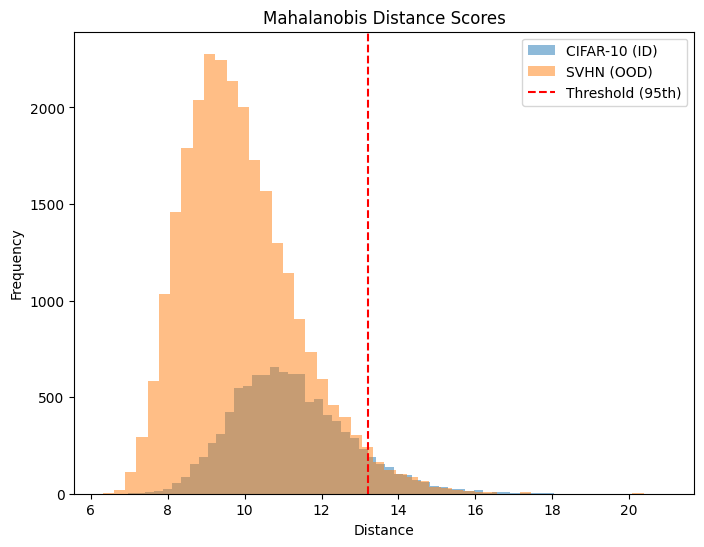

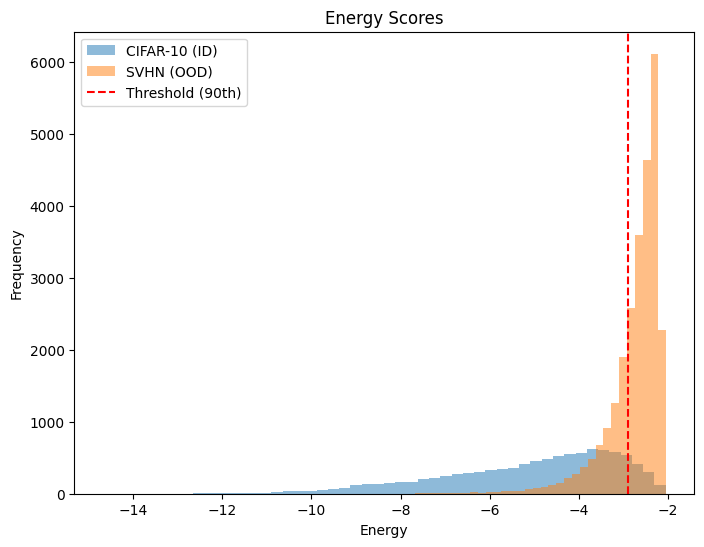

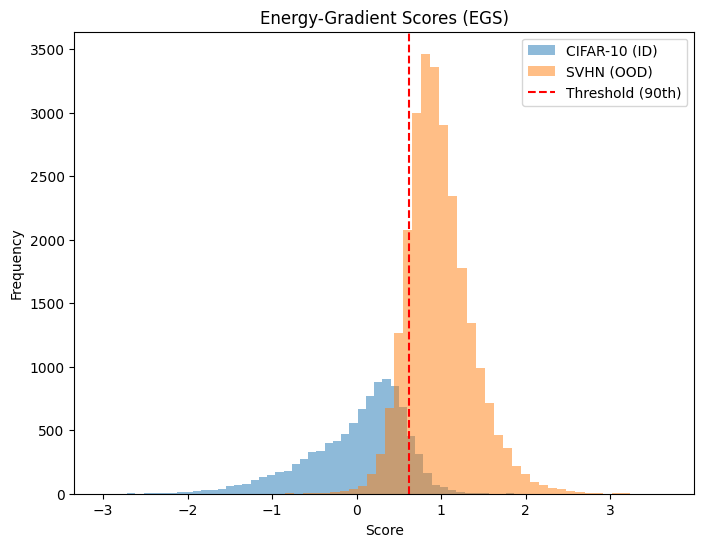

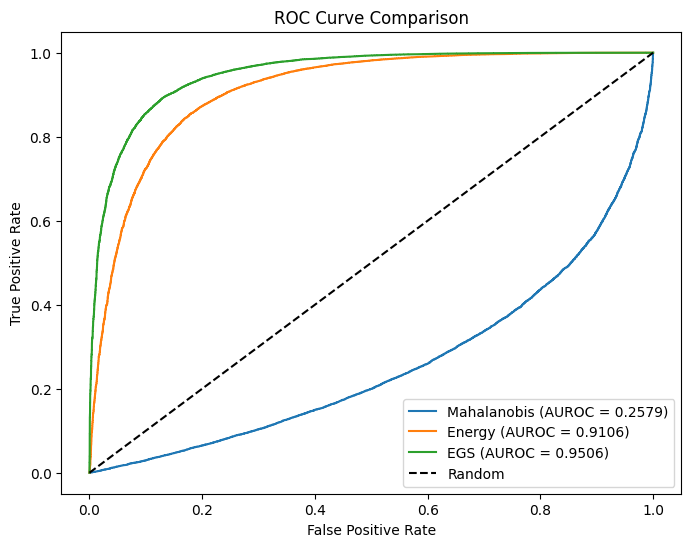

2025-06-18 06:33:51,290 - INFO - Training and evaluation completed.


In [11]:
def visualize_results(id_scores, ood_scores, id_energy, ood_energy, id_egs, ood_egs, mahalanobis_auroc, energy_auroc, egs_auroc, fpr, tpr, fpr_energy, tpr_energy, fpr_egs, tpr_egs):
    plt.figure(figsize=(8, 6))
    plt.hist(id_scores, bins=50, alpha=0.5, label='CIFAR-10 (ID)')
    plt.hist(ood_scores, bins=50, alpha=0.5, label='SVHN (OOD)')
    plt.axvline(np.percentile(id_scores, 90), color='r', linestyle='--', label='Threshold (95th)')
    plt.legend()
    plt.title('Mahalanobis Distance Scores')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.savefig('mahalanobis_histogram.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(id_energy, bins=50, alpha=0.5, label='CIFAR-10 (ID)')
    plt.hist(ood_energy, bins=50, alpha=0.5, label='SVHN (OOD)')
    plt.axvline(np.percentile(id_energy, 90), color='r', linestyle='--', label='Threshold (90th)')
    plt.legend()
    plt.title('Energy Scores')
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    plt.savefig('energy_histogram.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(id_egs, bins=50, alpha=0.5, label='CIFAR-10 (ID)')
    plt.hist(ood_egs, bins=50, alpha=0.5, label='SVHN (OOD)')
    plt.axvline(np.percentile(id_egs, 90), color='r', linestyle='--', label='Threshold (90th)')
    plt.legend()
    plt.title('Energy-Gradient Scores (EGS)')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.savefig('egs_histogram.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Mahalanobis (AUROC = {mahalanobis_auroc:.4f})')
    plt.plot(fpr_energy, tpr_energy, label=f'Energy (AUROC = {energy_auroc:.4f})')
    plt.plot(fpr_egs, tpr_egs, label=f'EGS (AUROC = {egs_auroc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.savefig('roc_curve_comparison.png')
    plt.show()

# Visualize the results
visualize_results(id_scores, ood_scores, id_energy, ood_energy, id_egs, ood_egs, mahalanobis_auroc, energy_auroc, egs_auroc, fpr, tpr, fpr_energy, tpr_energy, fpr_egs, tpr_egs)

logger.info("Training and evaluation completed.")

# Other Visualization

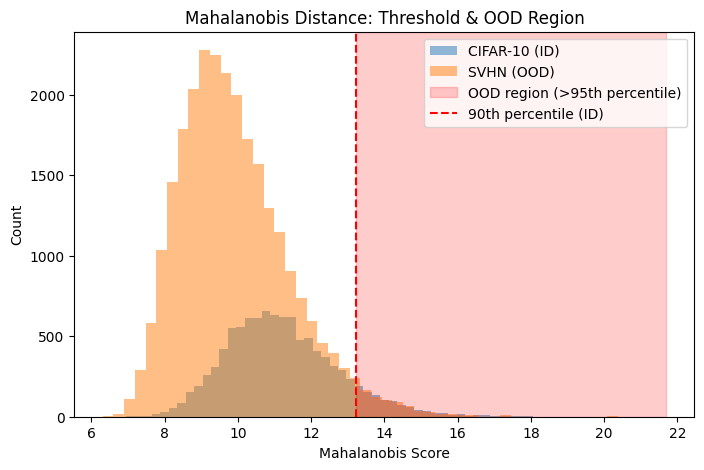

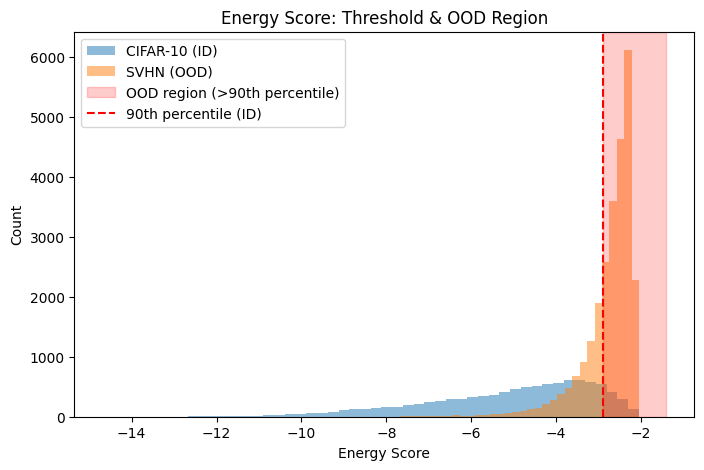

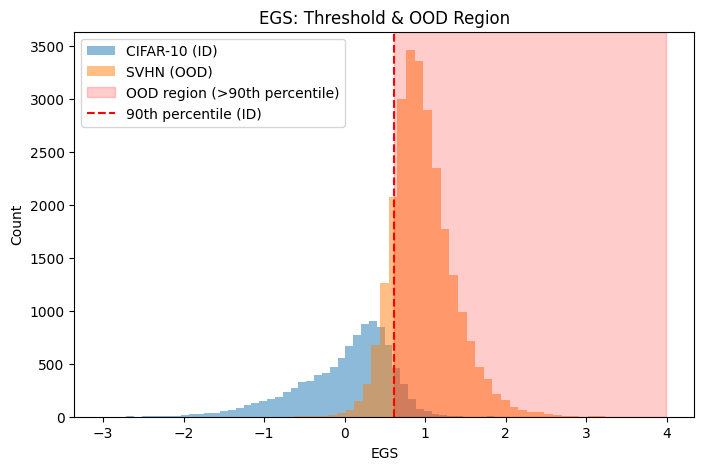

In [18]:
# Score Distribution with OOD Threshold Regions

plt.figure(figsize=(8, 5))
plt.hist(id_scores, bins=50, alpha=0.5, label='CIFAR-10 (ID)')
plt.hist(ood_scores, bins=50, alpha=0.5, label='SVHN (OOD)')
threshold = np.percentile(id_scores, 90)
plt.axvspan(threshold, plt.xlim()[1], color='red', alpha=0.2, label='OOD region (>95th percentile)')
plt.axvline(threshold, color='r', linestyle='--', label='90th percentile (ID)')
plt.legend()
plt.title('Mahalanobis Distance: Threshold & OOD Region')
plt.xlabel('Mahalanobis Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(id_energy, bins=50, alpha=0.5, label='CIFAR-10 (ID)')
plt.hist(ood_energy, bins=50, alpha=0.5, label='SVHN (OOD)')
threshold = np.percentile(id_energy, 90)
plt.axvspan(threshold, plt.xlim()[1], color='red', alpha=0.2, label='OOD region (>90th percentile)')
plt.axvline(threshold, color='r', linestyle='--', label='90th percentile (ID)')
plt.legend()
plt.title('Energy Score: Threshold & OOD Region')
plt.xlabel('Energy Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(id_egs, bins=50, alpha=0.5, label='CIFAR-10 (ID)')
plt.hist(ood_egs, bins=50, alpha=0.5, label='SVHN (OOD)')
threshold = np.percentile(id_egs, 90)
plt.axvspan(threshold, plt.xlim()[1], color='red', alpha=0.2, label='OOD region (>90th percentile)')
plt.axvline(threshold, color='r', linestyle='--', label='90th percentile (ID)')
plt.legend()
plt.title('EGS: Threshold & OOD Region')
plt.xlabel('EGS')
plt.ylabel('Count')
plt.show()

### Comparing Mahalanobis, Energy, and EGS for OOD Detection

Below, histograms visualize how three OOD detection scores separate in-distribution (CIFAR-10, blue) and out-of-distribution (SVHN, orange) samples:

- **Dashed red line:** Threshold (90th/95th percentile of ID scores)
- **Red shaded region:** Predicted OOD region (scores above threshold)

**Key Insights:**

- **Mahalanobis:** Shows poor separation. There is significant overlap between ID and OOD samples, leading to a large fraction of OOD points falling below the threshold. As a result, many OOD samples are incorrectly identified as in-distribution.
- **Energy:** Achieves noticeably better separation. Most OOD samples fall into the OOD region, while ID samples remain largely below the threshold.
- **EGS:** Offers the best separation. The OOD (orange) samples are highly concentrated in the OOD region, making it easier to distinguish from ID samples.

**Summary:**  
While Mahalanobis struggles to reliably distinguish OOD from ID, Energy improves performance, and EGS provides the most robust separation for OOD detection.


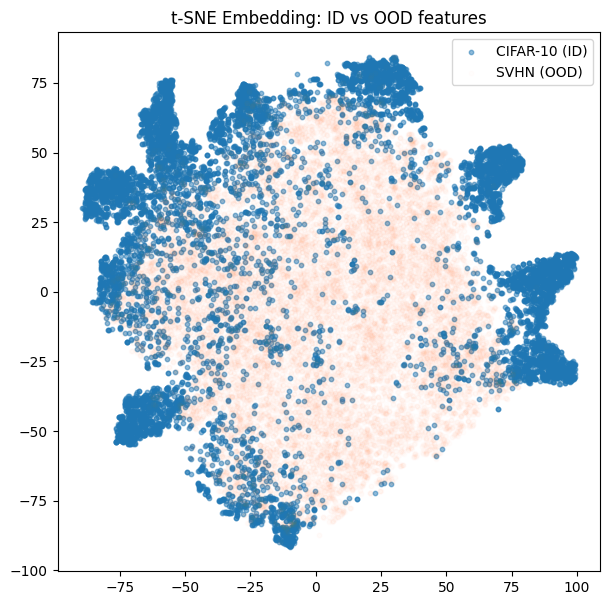

In [22]:
# t-SNE Feature Embedding Plots

from sklearn.manifold import TSNE

all_features = np.concatenate([id_features, ood_features], axis=0)
all_labels = np.array([0]*len(id_features) + [1]*len(ood_features))  # 0=ID, 1=OOD

emb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(all_features)
plt.figure(figsize=(7, 7))
plt.scatter(emb[all_labels==0,0], emb[all_labels==0,1], s=10, label='CIFAR-10 (ID)', alpha=0.5)
plt.scatter(emb[all_labels==1,0], emb[all_labels==1,1], s=10, label='SVHN (OOD)', alpha=0.01)
plt.legend()
plt.title("t-SNE Embedding: ID vs OOD features")
plt.show()

#### t-SNE Embedding: Visualizing ID vs OOD Feature Space

This plot shows a two-dimensional t-SNE projection of the encoder’s learned features for both in-distribution (CIFAR-10, blue) and out-of-distribution (SVHN, orange) samples.

- **Each point:** Represents a sample's feature vector, projected into 2D by t-SNE.
- **Colors:** Blue for in-distribution (ID), orange for out-of-distribution (OOD).

**Interpretation:**
- Well-separated clusters suggest the model’s learned features can distinguish between ID and OOD data.
- Significant overlap (as seen here) indicates some OOD samples are embedded similarly to ID samples—highlighting the challenge of OOD detection in feature space alone.
- t-SNE can capture local structure, so some regions are mostly ID or mostly OOD, but boundaries are fuzzy.

*This visualization provides an intuitive, global view of how well (or poorly) feature representations separate known and unknown data.*


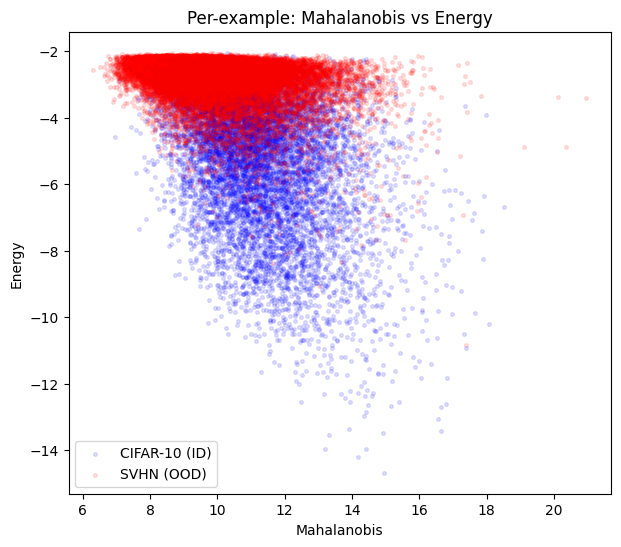

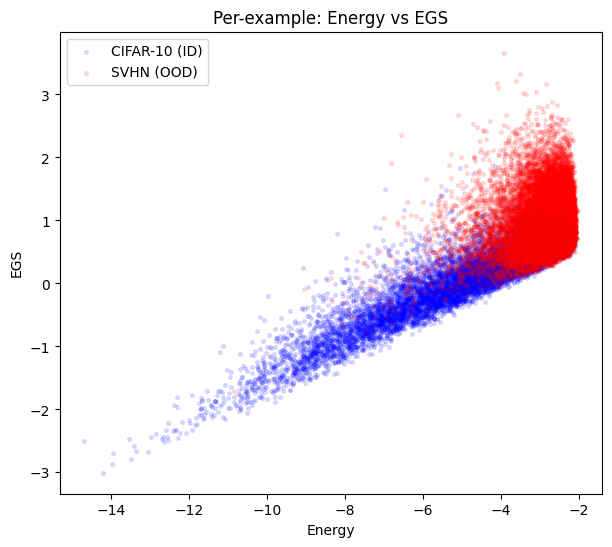

In [13]:
# Per-Example Score Scatter Plots

plt.figure(figsize=(7, 6))
plt.scatter(id_scores, id_energy, c='b', s=7, alpha=0.12, label='CIFAR-10 (ID)')
plt.scatter(ood_scores, ood_energy, c='r', s=7, alpha=0.12, label='SVHN (OOD)')
plt.xlabel("Mahalanobis")
plt.ylabel("Energy")
plt.title("Per-example: Mahalanobis vs Energy")
plt.legend()
plt.show()

plt.figure(figsize=(7, 6))
plt.scatter(id_energy, id_egs, c='b', s=7, alpha=0.12, label='CIFAR-10 (ID)')
plt.scatter(ood_energy, ood_egs, c='r', s=7, alpha=0.12, label='SVHN (OOD)')
plt.xlabel("Energy")
plt.ylabel("EGS")
plt.title("Per-example: Energy vs EGS")
plt.legend()
plt.show()

#### Per-example Scatter Plots: Comparing OOD Detection Scores

The scatter plots  visualize individual samples from both in-distribution (CIFAR-10, blue) and out-of-distribution (SVHN, red) datasets using pairs of OOD detection scores.

- **Top plot:** Each point shows one sample's Mahalanobis score (x-axis) and Energy score (y-axis).
- **Bottom plot:** Each point shows its Energy score (x-axis) and EGS (Energy-Gradient Score, y-axis).

**Interpretation:**
- These plots reveal how much agreement (or disagreement) there is between different scoring methods for OOD detection.
- If ID and OOD points cluster separately, the methods are capturing similar notions of “OOD-ness.” If not, they may be capturing complementary information.
- In the first plot, most OOD samples (red) have high Mahalanobis and high Energy scores, while ID samples (blue) are more spread out—showing the separation power of these metrics.
- In the second plot, the strong diagonal structure indicates EGS is strongly correlated with Energy, but can still capture additional uncertainty information, particularly at the OOD boundary.

*These per-example scatter plots help you visually diagnose which methods agree, which samples are "easy" or "hard," and where detection boundaries might lie.*


In [14]:
# Calibration Plot (ECE Reliability Diagram for Energy Scores)

def plot_reliability_diagram(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    binids = np.digitize(y_prob, bins) - 1
    accs = np.array([y_true[binids == i].mean() if np.any(binids == i) else np.nan for i in range(n_bins)])
    confs = np.array([y_prob[binids == i].mean() if np.any(binids == i) else np.nan for i in range(n_bins)])
    plt.figure(figsize=(6,5))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.plot(confs, accs, marker='o', label='Model')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram (ECE)')
    plt.legend()
    plt.show()

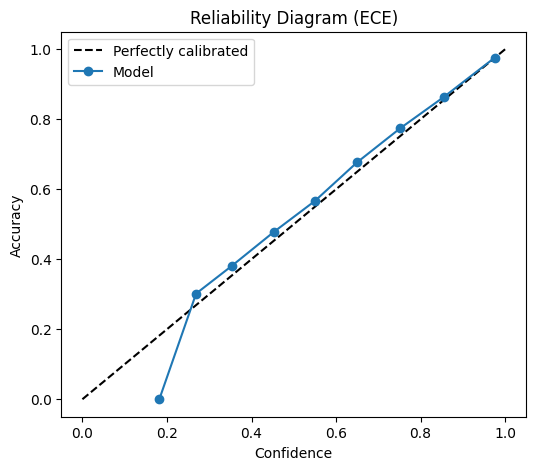

In [15]:
# Compute softmax confidence for each ID sample (for classifier on testloader)
# Here we use softmax max probability as "confidence"
all_probs = []
all_labels = []
classifier.eval()
moco_model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        features = moco_model.encoder_q(images)
        logits = classifier(features)
        probs = torch.softmax(logits, dim=1)
        max_probs, _ = probs.max(dim=1)
        all_probs.append(max_probs.cpu().numpy())
        all_labels.append((logits.argmax(1).cpu().numpy() == labels.numpy()).astype(float))
all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)

plot_reliability_diagram(all_labels, all_probs, n_bins=10)

#### Reliability Diagram (ECE): Model Calibration

The reliability diagram (or calibration curve) visualizes the relationship between predicted confidence and actual accuracy.

- **X-axis:** Model’s predicted confidence (e.g., maximum softmax probability in a bin).
- **Y-axis:** True accuracy for predictions in that confidence bin.
- **Dashed line:** Perfect calibration — if the model is well-calibrated, points lie on this diagonal (confidence = accuracy).

**Interpretation:**  
- If the curve is **above** the diagonal, the model is **under-confident** (accuracy > confidence).
- If the curve is **below** the diagonal, the model is **over-confident** (confidence > accuracy).
- In this plot, the model is generally well-calibrated, as the curve closely follows the ideal line.

**ECE (Expected Calibration Error)** quantifies the average difference between confidence and accuracy across bins—a lower ECE indicates better calibration.

*Well-calibrated probabilities are important for reliable uncertainty estimates in OOD detection and risk-sensitive applications.*


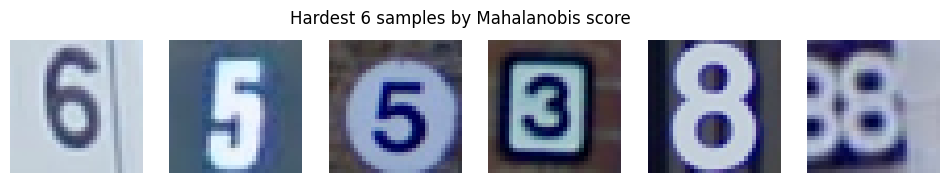

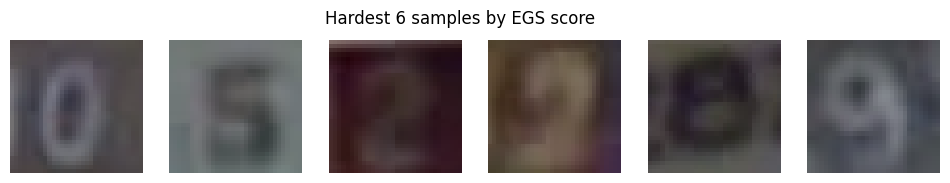

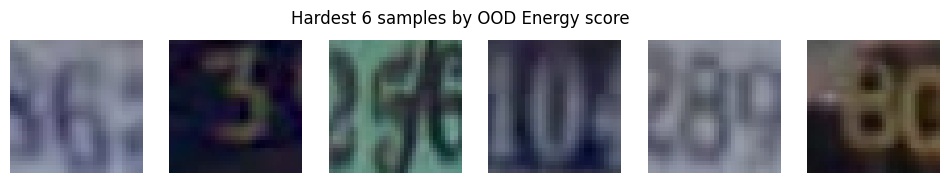

In [21]:
# Visualize “Hard” and “Easy” Cases

import random

def show_examples(imageset, scores, title, top=True, n=6):

    idx_sorted = np.argsort(scores)
    if top:
        idx = idx_sorted[-n:]
        which = "Hardest"
    else:
        idx = idx_sorted[:n]
        which = "Easiest"
    plt.figure(figsize=(12, 2))
    for i, idxi in enumerate(idx):
        img, _ = imageset[idxi]
        img = img.permute(1,2,0).numpy()
        img = (img * 0.2010 + 0.4465)  # Unnormalize
        img = np.clip(img, 0, 1)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"{which} {n} samples by {title} score")
    plt.show()

# Example usage:
show_examples(oodset, ood_scores, "Mahalanobis", top=True)
show_examples(oodset, ood_egs, "EGS", top=True)
# show_examples(testset, id_energy, "Energy", top=True)
show_examples(oodset, ood_energy, "OOD Energy", top=True)

#### Hardest OOD Examples: Where Detectors Struggle Most

Above, we visualize the six “hardest” out-of-distribution (OOD) SVHN samples according to each scoring method.  
- **Hard** = highest (most in-distribution-like) score for that method, i.e., samples most likely to be misclassified as in-distribution.

- **Top row:** Hardest by Mahalanobis score — these are typically clear, well-formed digits, indicating that Mahalanobis struggles to distinguish some OOD samples if they closely resemble in-distribution data.
- **Middle row:** Hardest by EGS score — these are mostly blurry, ambiguous digits or images with unusual appearance, suggesting EGS is sensitive to feature ambiguity and uncertainty.
- **Bottom row:** Hardest by Energy score — again, blurry or low-contrast digits, which may confuse the classifier’s confidence.

**Interpretation:**  
Each method fails in different ways:  
- Mahalanobis struggles when OOD samples look visually typical.
- Energy and EGS may struggle more with image ambiguity or degradation.

*Visualizing hard cases helps diagnose the strengths and weaknesses of OOD detectors, and reveals what kinds of errors each method tends to make.*


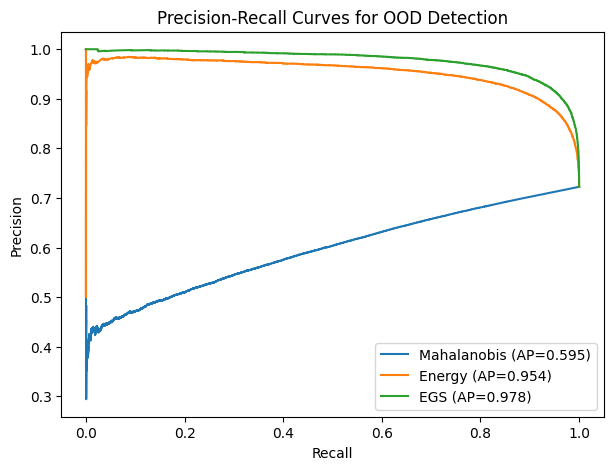

In [16]:
# Precision-Recall Curves

from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(id_vals, ood_vals, method_name):
    labels = np.concatenate([np.zeros_like(id_vals), np.ones_like(ood_vals)])
    scores = np.concatenate([id_vals, ood_vals])
    precision, recall, _ = precision_recall_curve(labels, scores)
    ap = average_precision_score(labels, scores)
    plt.plot(recall, precision, label=f"{method_name} (AP={ap:.3f})")

plt.figure(figsize=(7,5))
plot_pr_curve(id_scores, ood_scores, "Mahalanobis")
plot_pr_curve(id_energy, ood_energy, "Energy")
plot_pr_curve(id_egs, ood_egs, "EGS")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for OOD Detection")
plt.legend()
plt.show()

#### Why is there a vertical spike at recall = 0 in the Precision-Recall curve?

At the far left of the PR curve (recall near zero), you often see a **vertical spike**. This occurs because, at the strictest detection threshold, the model only predicts a few samples as OOD—and these are typically its most confident, high-scoring cases.

- For these few predictions, **precision is perfect (1.0)** because all flagged samples are truly OOD.
- However, **recall is near zero** because only a tiny fraction of all actual OOD samples have been detected so far.

As the threshold is relaxed, recall increases (more OODs detected), but precision may drop as some ID samples begin to be misclassified.

This phenomenon is especially pronounced when the OOD detector is very confident and separable (as with Energy or EGS scores), resulting in a sharp vertical segment at low recall.

**In summary:**  
A vertical spike at recall ≈ 0 means the detector makes a few extremely confident and perfectly correct OOD predictions before any false positives appear.


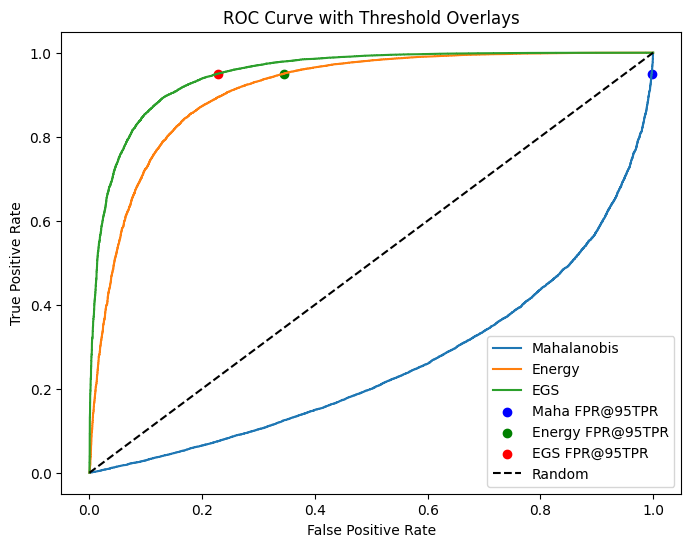

In [18]:
# Overlay OOD Thresholds on ROC

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Mahalanobis')
plt.plot(fpr_energy, tpr_energy, label=f'Energy')
plt.plot(fpr_egs, tpr_egs, label=f'EGS')
# Overlay thresholds (FPR@95TPR)
idx = np.where(tpr >= 0.95)[0][0]
plt.scatter(fpr[idx], tpr[idx], color='b', marker='o', label='Maha FPR@95TPR')
idx_e = np.where(tpr_energy >= 0.95)[0][0]
plt.scatter(fpr_energy[idx_e], tpr_energy[idx_e], color='g', marker='o', label='Energy FPR@95TPR')
idx_eg = np.where(tpr_egs >= 0.95)[0][0]
plt.scatter(fpr_egs[idx_eg], tpr_egs[idx_eg], color='r', marker='o', label='EGS FPR@95TPR')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Threshold Overlays')
plt.legend()
plt.show()

### ROC Curve Comparison: Mahalanobis vs Energy vs EGS

The plot above shows the ROC curves for three OOD detection methods—Mahalanobis, Energy, and Energy-Gradient Score (EGS). Each colored dot indicates the **FPR (False Positive Rate) at 95% TPR (True Positive Rate)** for that method.

**Key Points:**
- **Mahalanobis:** The ROC curve is much lower, indicating poor OOD/ID separation. Its FPR@95TPR is much higher (blue dot), meaning many ID samples are mistakenly classified as OOD at high sensitivity.
- **Energy:** The curve is significantly better than Mahalanobis, with a lower FPR@95TPR (green dot). Energy scores provide better separation between ID and OOD samples.
- **EGS:** Achieves the best overall performance (red dot). The ROC curve nearly touches the upper left corner, and FPR@95TPR is lowest among all methods.

**Summary:**  
Mahalanobis scores struggle for reliable OOD detection, while Energy improves separation, and EGS yields the most accurate and robust results for high-sensitivity OOD detection.


In [17]:
import pandas as pd
import numpy as np

# Detection rate @ 90th percentile (use ID test set 90th percentile as threshold)
maha_thresh = np.percentile(id_scores, 90)
maha_det_rate = (ood_scores > maha_thresh).mean()

energy_thresh = np.percentile(id_energy, 90)
energy_det_rate = (ood_energy > energy_thresh).mean()

egs_thresh = np.percentile(id_egs, 90)
egs_det_rate = (ood_egs > egs_thresh).mean()

# FPR@95TPR helper
def get_fpr_at_95tpr(fpr, tpr):
    idx = np.where(tpr >= 0.95)[0]
    return fpr[idx[0]] if len(idx) > 0 else np.nan

maha_fpr_95 = get_fpr_at_95tpr(fpr, tpr)
energy_fpr_95 = get_fpr_at_95tpr(fpr_energy, tpr_energy)
egs_fpr_95 = get_fpr_at_95tpr(fpr_egs, tpr_egs)

# AUROC values already returned by your functions
results = {
    "AUROC": [mahalanobis_auroc, energy_auroc, egs_auroc],
    "Detection Rate @90th": [maha_det_rate, energy_det_rate, egs_det_rate],
    "FPR@95TPR": [maha_fpr_95, energy_fpr_95, egs_fpr_95]
}
index = ["Mahalanobis", "Energy Score", "EGS"]

df = pd.DataFrame(results, index=index)
display(df.style.format("{:.4f}"))


,AUROC,Detection Rate @90th,FPR@95TPR
Mahalanobis,0.2579,0.0295,0.9973
Energy Score,0.9106,0.7244,0.3446
EGS,0.9506,0.8557,0.2281


## **Final Conclusion: OOD Detection Results & Method Comparison**

Our evaluation on CIFAR-10 (ID) vs SVHN (OOD) reveals strong differences in OOD detection performance across Mahalanobis, Energy Score, and EGS methods:

|            | AUROC  | Detection Rate @90th | FPR@95TPR |
|------------|--------|----------------------|-----------|
| **Mahalanobis**  | 0.2579 | 0.0295               | 0.9973    |
| **Energy Score** | 0.9106 | 0.7244               | 0.3446    |
| **EGS**         | 0.9506 | 0.8557               | 0.2281    |

**Key takeaways:**

- **Mahalanobis performs poorly** on this setup. The AUROC is low, and both Detection Rate and FPR@95TPR are close to random guessing.
- **Energy Score and EGS both excel,** showing high AUROC, strong detection at the 90th percentile, and much lower FPR@95TPR.

---

### **Why Does Mahalanobis Fail, While Energy and EGS Succeed?**

- **Mahalanobis Distance** relies on the assumption that ID features form a compact Gaussian cluster in feature space. With self-supervised pretraining (MoCo), the learned features for CIFAR-10 are more dispersed, and OOD samples (SVHN) often overlap with the ID region. This breaks the Gaussian/compactness assumption, leading to poor separation and unreliable OOD detection.

- **Energy Score** leverages the log-sum-exp of logits, which reflects the model’s confidence. For ID samples, the classifier is confident (low energy); for OOD, the classifier is uncertain (high energy). This direct connection to prediction confidence makes Energy Score robust—even when features are not tightly clustered.

- **EGS (Energy-Gradient Score)** combines Energy with the feature-space gradient norm, capturing both prediction confidence and local feature sensitivity. This makes EGS even more discriminative and robust to complex or entangled feature spaces.

---

**Bottom line:**  
On this benchmark, **Energy Score and EGS are much more reliable than Mahalanobis distance** for OOD detection, especially when features are learned via self-supervised or contrastive methods.

---

_Cite: Liu et al., "Energy-based Out-of-distribution Detection" (NeurIPS 2020)_
